# Programmierübung 1 zu *Grundlagen der Optimierung* (WS2021)

## Einführung

### Verantwortlich
* Prof. Dr. Roland Herzog
* Dr. Georg Müller
* M.Sc. Masoumeh Hashemi

Die Webseite dieser Veranstaltung finden Sie unter [https://tinyurl.com/scoop-gdo](https://tinyurl.com/scoop-gdo).

### Zielsetzung
Das Ziel dieses *Jupyter Notebooks* ist es, Ihnen das Verhalten der im Kapitel 1 des Skripts vorgestellten Algorithmen zur Lösung allgemeiner, unrestringierter Optimierungsprobleme nahezubringen.
Wir werden
1. den Einfluss der *Vorkonditionierer* im *Gradientenverfahren* untersuchen und
1. die Vorteile des *Newton-Verfahrens* gegenüber dem Gradientenverfahren herausarbeiten.

### Zur Nutzung des Notebooks
Die numerische Umsetzung der Verfahren und die graphische Visualisierung typischer Ergebnisse ist ein essentieller Baustein auf dem Weg zu einem ausgereiften Verständnis der Algorithmen.
Um programmiertechnische Schwierigkeiten weitestgehend auszuschließen, haben wir einiges an Code für Sie vorbereitet.
An den Schlüsselstellen der jeweiligen Implementierungen wurde der lauffähige Code durch auskommentierte Blöcke der Art
```python
### TODO BEGIN ###
# Compute the preconditioned gradient and the square of its (preconditioner-induced) norm 
# gradient = ...
# norm2_gradient = ...
### TODO END ###
```
ersetzt, in denen Sie zwischen `### TODO BEGIN ###` und `### TODO END ###` die entsprechenden Anweisungen Variablen (in diesem Beispiel die Berechnung von `gradient` und `norm2_gradient`) entsprechend des Kommentars ausführen, um Lauffähigkeit wieder herzustellen.
Welche Berechnungen und Auswertungen an den jeweiligen Stellen benötigt werden, können Sie im Skript nachlesen.
Sie können natürlich, bevor Sie genau diese vorbenannten Variablen schreiben, auch eigene Variablen beschreiben.

Wenn sie den Code vervollständigt haben, werden Sie an geeigneter Stelle um die Interpretation der Ergebnisse gebeten.
In den entsprechenden Zellen ersetzen Sie "**TODO Ihre Antwort hier**" mit ihrer Antwort.

## Das Gradientenverfahren für quadratische Zielfunktionen
In diesem Abschnitt wollen wir das Verhalten des *Gradientenverfahrens* bei *quadratischen Zielfunktionen* mit symmetrischem, positiv definitem quadratischen Teil bei Verwendung der *exakten Schrittweitenbestimmung* untersuchen.
Wir wollen hier insbesondere den Einfluss des Vorkonditionierers auf die Konvergenzgeschwindigkeit untersuchen, denn
wie wir wissen kann man in diesem Fall die *q-lineare Konvergenz* des Gradientenverfahrens gegen den eindeutigen Minimierer des Problems beweisen und kann sogar den Vorfaktor explizit in Abhängigkeit von der *verallgemeinerten Konditionszahl* angeben.

### Implementierung des Gradientenverfahrens
In der nachfolgenden Zelle finden Sie die Funktion zum Gradientenverfahren mit den fehlenden Berechnungen.

**Aufgabe:** Vervollständigen Sie den Code und führen Sie die Zelle aus.

Beachten Sie, dass sowohl die verwendete Schrittweitenberechnung als auch die Wahl des Vorkonditionierers - mit gutem Grund - durch den/die AnwenderIn explizit vorgegeben werden muss.

In [1]:
# This module implements the preconditioned gradient scheme.

import numpy as np

def gradient_descent(f, x0, step_length_rule, preconditioner, parameters = {}):
  """ 
  Solve an unconstrained minimization problem using the preconditioned
  gradient descent method.

  Accepts:  
                   f: the objective function to be minimized
                  x0: the initial guess (list or numpy array with ndim == 1)
    step_length_rule: a step length computation function 
      preconditioner: a symmetric positive definite matrix (numpy array with ndim == 2)
          parameters: optional parameters (dictionary);
                      the following key/value pairs are evaluated:
                                ["atol_x"]: absolute stopping tolerance for the norm of updates in x
                                ["rtol_x"]: relative stopping tolerance for the norm of updates in x
                                ["atol_f"]: absolute stopping tolerance for the progress in the values of f
                                ["rtol_f"]: relative stopping tolerance for the progress in the values of f
                            ["atol_gradf"]: absolute stopping tolerance for the norm of the gradient of f
                            ["rtol_gradf"]: relative stopping tolerance for the norm of the gradient of f
                        ["max_iterations"]: maximum number of iterations
                             ["verbosity"]: "verbose" or "quiet"
                          ["keep_history"]: whether or not to store the iteration history (True or False) 
                      Here 'norm' refers to the preconditioner-induced norm.
    
  Returns: 
              result: a dictionary containing 
                          solution: final iterate
                          function: the final iterate's objective value 
                          gradient: the final iterate's objective gradient value
                     norm_gradient: preconditioner-induced norm of final objective gradient 
                              iter: number of iterations performed
                          exitflag: flag encoding why the algorithm terminated
                                   0: stopping tolerance described by atol_x, rtol_x, atol_f, rtol_f reached
                                   1: stopping tolerance described by atol_gradf and rtol_gradf reached
                                   2: maximum number of iterations reached

                       history: a dictionary for the history of the run containing
                                          iterates: the iterates x
                                  objective_values: the values of the objective function
                                    gradient_norms: the norms of the objective function gradient 
                                     steps_lengths: the step lengths chosen by the step length rule
  """
  # Define computation of the squared preconditioner norm
  def norm2(d): return d.dot(preconditioner.dot(d))

  # Define an output function that will be used to print information on the state of the iteration
  def print_header(): 
    print('--------------------------------------------------------------------')
    print(' ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           ')
    print('--------------------------------------------------------------------')
  
  # Define exitflags messages that will be printed when the algorithm terminates
  exitflag_messages = [
      'Relative and absolute tolerances on the norm of the update and the descent of the objective are satisfied.',
      'Relative and absolute tolerances on the norm of the gradient are satisfied.',
      'Maximum number of optimization steps is reached.',
      ]
  
  # Get the algorithmic parameters, using defaults if missing
  atol_x = parameters.get("atol_x", 1e-6)
  rtol_x = parameters.get("rtol_x", 1e-6)
  atol_f = parameters.get("atol_f", 1e-6)
  rtol_f = parameters.get("rtol_f", rtol_x**2)
  atol_gradf = parameters.get("atol_gradf", 1e-6)
  rtol_gradf = parameters.get("rtol_gradf", 1e-6)
  max_iterations = parameters.get("max_iterations", 1e3)
  verbosity = parameters.get("verbosity", "quiet")
  keep_history = parameters.get("keep_history", False)

  # Initialize the iterates, counters etc.
  x = x0
  iter = 0
  exitflag = None
  
  # Initialize dummy values pertaining to the previous iterate
  x_old = np.full(x0.shape, np.inf)
  function_value_old = np.inf

  # Prepare a dictionary to store the history
  if keep_history:
    history = {
      "iterates" : [],
      "objective_values" : [],
      "gradient_norms" : [],
      "step_lengths" : []
      }
  
  # Perform gradient descent steps until one of the termination criteria is met
  while exitflag is None:
    # Record the current iterate
    if keep_history: history["iterates"].append(x)
    
    # Dump some output
    if verbosity == 'verbose':
      if (iter%10 == 0): print_header()
      print(' %4d  ' % (iter), end = '')
            
    # Stop when the maximum number of iterations has been reached
    if iter >= max_iterations:
      exitflag = 2
      break
    
    # Compute the function value and derivative at current iterate
    values = f(x, derivatives = [True, True, False])
    function_value = values["function"]
    derivative = values["derivative"]
    
    # Record the current value of the objective
    if keep_history: history["objective_values"].append(function_value)
        
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  ' % (function_value), end = '')
    
    # Compute the preconditioned gradient and the square of its (preconditioner-induced) norm
    gradient = np.linalg.solve(preconditioner, derivative)
    norm2_gradient = derivative.dot(gradient)
    
    # Check the computed norm square for positivity
    if norm2_gradient < 0:
      raise ValueError('Your preconditioner appears not to be positive definite.')
    else:
      norm_gradient = np.sqrt(norm2_gradient)
    
    # Record the current norm of the gradient
    if keep_history: history["gradient_norms"].append(norm_gradient)

    # Remember the norm of the initial gradient
    if (iter == 0): initial_norm_gradient = norm_gradient
        
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  ' % (norm_gradient), end = '')
    
    # Stop when the stopping tolerance on the norm of the gradient has been reached
    if norm_gradient <= atol_gradf + rtol_gradf * initial_norm_gradient:
      exitflag = 1
      break
    
    # Evaluate the norm of the update step
    norm_delta_x = np.sqrt(norm2(x - x_old))
    
    # Evaluate the change in the objective function values
    delta_f = function_value_old - function_value
    
    # Evaluate the reference values for relative tolerances
    abs_function_value_old = np.abs(function_value_old)
    norm_x_old = np.sqrt(norm2(x_old))
    
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  %11.4e' % (norm_delta_x, -delta_f))
    
    # Stop when the stopping tolerance on the change in the objective and the
    # norm of the update step have been reached
    if (delta_f < atol_f + rtol_f * abs_function_value_old) and\
      (norm_delta_x < atol_x + rtol_x * norm_x_old):
      exitflag = 0
      break
    
    # Set the update direction
    d = -gradient
    
    # Prepare the line search function, using the function values of the
    # objective and its derivatives and the chain rule
    def phi(t, derivatives):
      values = f(x + t * d, derivatives)
      if derivatives[1]:
        values["derivative"] = values["derivative"].dot(d)
      if derivatives[2]:
        values["Hessian"] = d.dot(values["Hessian"].dot(d))
      return values
    
    # Prepare some data to pass down to the step length computation rule
    reusables = {
      "phi0" : function_value,
      "dphi0" : -norm2_gradient
      }
    
    # Evaluate the step length t using the step length rule
    t, t_exitflag = step_length_rule(phi, reusables)
    
    # Check whether of not the step length was computed succesfully
    if t_exitflag: raise AssertionError('Step length was not computed succesfully.')
    
    # Record the chosen step length
    if keep_history: history["step_lengths"].append(t)
    
    # Save the current iterate and associated function value for the next iteration
    x_old = x
    function_value_old = function_value
    
    # Update the iterate and increase the counter
    x = x + t * d
    iter = iter + 1

  # Dump some output
  if verbosity == 'verbose':
    print('\n\nThe gradient descent method exiting with flag %d.\n' %(exitflag) + str(exitflag_messages[exitflag])+'\n' )
  
  # Create and populate the result to be returned
  result = {
    "solution" : x,
    "function" : function_value,
    "gradient" : gradient,
    "norm_gradient" : norm_gradient,
    "iter" : iter,
    "exitflag" : exitflag
    }

  # Assign the history to the result if required
  if keep_history:
    result["history"] = history
      
  return result


### Implementierung der exakten quadratischen Schrittweite

Um das oben implementierte Gradientenverfahren im Rahmen dieses Abschnitts untersuchen zu können, benötigen wir lediglich noch die Schrittweitensteuerung.

**Aufgabe:** Vervollständigen Sie den Code in der nächsten Zelle und führen Sie die Zelle aus.

Beachten Sie, dass das Interface der Schrittweitenbestimmung lediglich den *Schnitt* $\varphi$ der Funktion $f$ übergeben bekommt. 
Sie müssen also den Ausdruck in Abhängigkeit von dem quadratischen Teil $Q$ der Zielfunktion und dem Vorkonditionierer $M$ aus dem Skript durch durch $\varphi$-Terme ausdrücken.

In [2]:
# This module implements the exact step length computation for quadratic objective functionals in the gradient scheme

import numpy as np

def exact_step_length_quadratic(phi, reusables = {}):
  """ 
  Compute the exact minimizer of a one-dimensional function assumed
  to be a quadratic polynomial.

  Accepts: 
           phi: evaluates the function the line search is performed on
     reusables: additional information that may be provided to the method (dictionary);
                the following key/value pairs are evaluated:
                  ["phi0"]: the value of phi at t = 0 (scalar)
                  ["dphi0"]: the value of the derivative of phi at t = 0 (scalar)

  Returns:
            t: the step length minimizing phi (provided it is quadratic)
     exitflag: 0
  """

  # The exact minimizer of phi is evaluated using the following data:
  # phi(0), phi'(0), phi(1). Evaluate this data if it is not provided.
  phi0 = reusables.get("phi0", phi(0, derivatives = [True, False, False])["function"]) or\
    phi(0, derivatives = [True,False,False])["function"]
  dphi0 = reusables.get("dphi0", phi(0, derivatives=[False, True, False])["derivative"]) or\
    phi(0, derivatives = [False,True,False])["derivative"]
  if dphi0 >= 0:
    raise(InputError('The function phi is expected to be decreasing at zero..'))
  phi1 = phi(1,derivatives = [True, False, False])["function"]
  
  # Evaluate the exact step length
  t = - dphi0 / ( 2 * (phi1 - phi0 - dphi0))
  
  # Check if the step length is in fact positive, i.e., whether phi has positive curvature.
  if t < 0.0:
    raise ValueError('The step length computation yields a negative step length.')
  else:
    return t, 0

### Untersuchung des Verhaltens der Iterierten

An dieser Stelle können wir bereits mit unserer Untersuchung beginnen.
Das Skript in der nächsten Zelle soll das implementierte Gradientenverfahren mit verschiedenen Vorkonditionierern auf ein quadratisches Problem anwenden und die verallgemeinerten Konditionszahlen berechnen.
Der Output entspricht dem Status des Gradientenverfahren in den jeweiligen Iterationen.
Das Skript ist lauffähig und verwendet die euklidische Vorkonditionierung.

**Aufgabe:** Implementieren Sie zu dem euklidischen Vorkonditionierer mindestens drei weitere Vorkonditionierer.
Achten Sie darauf, auch einen zu implementieren, der zu langsamerer Konvergenz als der euklidische, führt.

In [3]:
import sys
sys.path.append('src/')

import numpy as np

from objective_functions import *
from scipy.linalg import eigh
from visualization_functions import *

# Create data
Q = np.array([[10.0, -2.0], [-2.0, 1.0]])
c = np.array([2.0, 0.0])
gamma = 0.0
f = lambda u, derivatives: quadratic_function(u, derivatives, Q, c, gamma)
x0 = np.array([1.0, 5.0])

# Construct step length rule
exact_step_length_rule_quadratic = lambda phi, reusables: exact_step_length_quadratic(phi, reusables)

# Construct a "random" spd matrix with small entries
rand_spd = np.random.rand(Q.shape[0], Q.shape[1])
rand_spd = 0.5 * (rand_spd.T + rand_spd) + Q.shape[0] * np.identity(Q.shape[0])
rand_spd = 1e-2 * rand_spd

# Construct the preconditioners
preconditioners = [(Q[::-1,::-1].T, "Q_T"),           # Transposed Q along antidiagonal
                  (np.identity(len(x0)), "Identity"), # Identity                  
                  (np.diag(np.diag(Q)), "Diagonal"),  # Diagonal of Q
                  (Q +  rand_spd, "Q + eps * R"),     # Mildly perturbed Q
                  (Q, "Q")]                           # Q

# Set gradient scheme parameters
optimization_parameters = {
"atol_x" : 1e-7,
"rtol_x" : 1e-7,
"atol_f" : 1e-7,
"rtol_f" : 1e-14,
"max_iterations" : 1e4,
"c" : 10,
"verbosity" : "verbose",
"keep_history" : True
}

outputs = []
labels = []
generalized_condition_numbers = []

# Solve problem for all choices of the preconditioner
for preconditioner, label in preconditioners:
  outputs.append(gradient_descent(f, x0, exact_step_length_rule_quadratic, 
                                 preconditioner, optimization_parameters))
  labels.append(label)
  generalized_eigenvalues = eigh(Q, preconditioner, eigvals_only = True)
  generalized_condition_numbers.append(generalized_eigenvalues[-1] / generalized_eigenvalues[0])

--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
    0   9.5000e+00   3.4881e+00          nan         -inf
    1   9.0618e+00   1.1634e+00   2.5124e-01  -4.3817e-01
    2   8.6432e+00   3.3326e+00   7.1971e-01  -4.1864e-01
    3   8.2432e+00   1.1115e+00   2.4004e-01  -3.9999e-01
    4   7.8610e+00   3.1841e+00   6.8764e-01  -3.8217e-01
    5   7.4959e+00   1.0620e+00   2.2935e-01  -3.6514e-01
    6   7.1470e+00   3.0423e+00   6.5700e-01  -3.4887e-01
    7   6.8137e+00   1.0147e+00   2.1913e-01  -3.3332e-01
    8   6.4952e+00   2.9067e+00   6.2772e-01  -3.1847e-01
    9   6.1910e+00   9.6946e-01   2.0936e-01  -3.0428e-01
--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
   10 

Falls der Code in der vorherigen Zelle durchgelaufen ist, können wir nun die Höhenlinien der Zielfunktion und die von den verschiedenen Durchläufen besuchten Iterierten plotten.
Führen Sie dazu die folgende Zelle aus, Sie müssen nichts ergänzen.

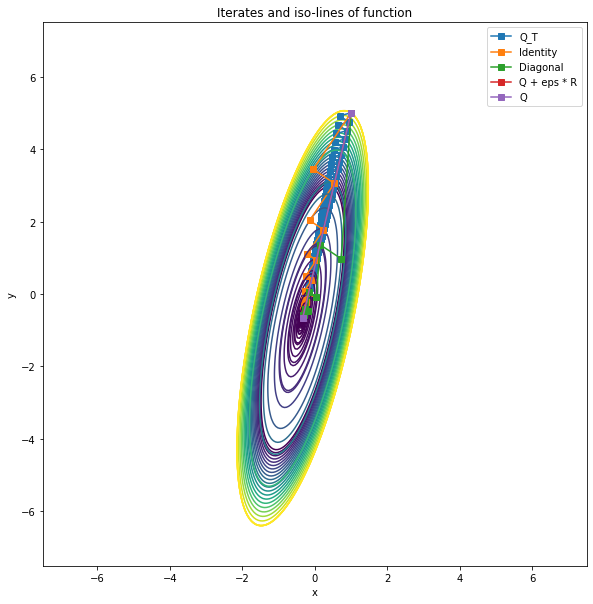

In [4]:
# Plot history in iterate space
plot_2d_iterates_contours(f, list(out["history"] for out in outputs), labels)

**Aufgabe:** Beschreiben Sie den Einfluss der von Ihnen gewählten Vorkonditionierer auf den Verlauf der Iterationen.

**TODO Ihre Antwort hier**

Aufgelistet von der besten zur schlechtesten Performance:
1. Die Wahl des Vorkonditionierers $M=Q$ löst das Problem natürlich in einem Schritt, denn die Berechnung des Gradienten und das Ausführen des Updates entspricht dem direkten Lösen der Optimalitätsbedingungen erster Ordnung, die für dieses Problem hinreichend sind.
Das sieht man auch daran, dass die relative Konditionszahl $1$ ist - damit ist der Vorfaktor in der linearen Konvergenz $0$ und $x^{(1)}$ muss die Lösung sein.
Die Iterationen gehen also in einem Schritt in direkter Verbindung zum Minimierer.
1. Addiert man eine leichte, zufällige (symmetrisch, positiv definite) Störung auf Q, so erhält man Lösungsschritte, die die Aufgabe *fast* lösen und sehr schnell zu guten Ergebnissen führen. 
Hier sind geringfügig mehr Iterationen notwendig.
1. Wählt man die Diagonale von $Q$ als $M$, so hat man je nach Lage der Eigenwertachsen eine gute Approximation von $Q$, die günstig zu invertieren ist.
In unserem Beispiel liegen die Eingenvektoren verhältnismäßig günstig, man sieht zum ersten mal das Zick-Zack-Verhalten des Verfahrens, die Schritte sind aber groß.
1. Wählt man die Identität als Vorkonditionierer (euklidisches Skalarprodukt), dann verliert die Qualität der Richtungen merklich, denn es sind garkeine Informationen von $Q$ mehr eingeflossen.
Das Verfahren zeigt starkes Zick-Zack-Verhalten.
1. Dass Informationen aus $Q$ auch zu Verschlechterung der Konvergenzgeschwindigkeit führen können, wenn man sie falsch verwendet, zeigt das letzte Beispiel, wo der Vorkonditionierer als die Anti-Transponierte (Transponierte entlang der Anti-Diagonalen) gewählt wurde.
Hier wurden (informell gesprochen) die Eigenwertachsen der Matrix in etwa vertauscht, die Krümmungsinformationen der Parabel, die von dem Vorkonditionierer geschätzt wird, ist also fast genau entgegengesetzt zu der tatsächlichen Krümmung.
Das Verfahren tut sich unter diesen Voraussetzungen sehr schwer.

### Untersuchung des Konvergenzverhaltens

Nun wollen wir uns noch das Konvergenzverhalten im Sinne der Energienorm des Fehlers ansehen.
Für unser obiges Problem können wir nämlich den exakten Minimierer direkt bestimmen. 
Mit den Aussagen im Konvergenzbeweis können wir nun die (quadrierte) Energienorm des Fehlers in jeder Iteration gegen eine in dem Vorfaktor $\frac{k-1}{k+1}$ exponentiell fallende Folge abschätzen und als obere Schranke plotten.

**Aufgabe: Berechnen Sie den exakten Minimierer.**

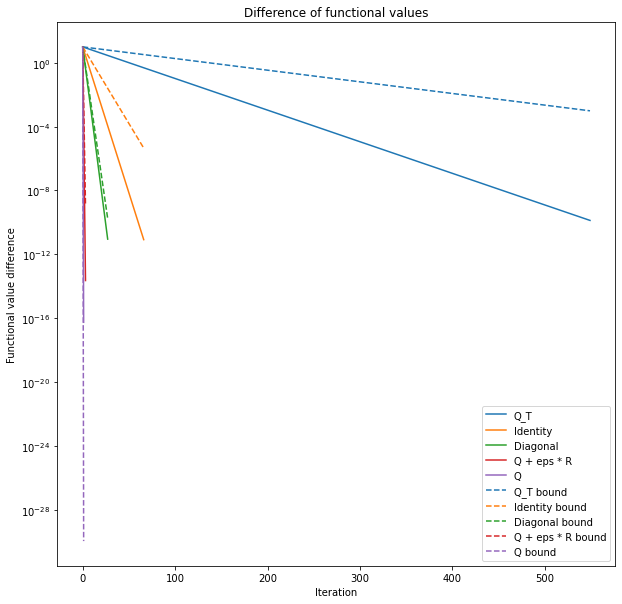

In [5]:
# Compute the actual solution of the problem and its function value for verification
x_opt = np.linalg.solve(Q,-c)
f_opt = f(x_opt, derivatives = [True, False, False])["function"]

# Plot functional value differences (approximation of error energy norm)
plot_f_val_diffs(list(out["history"] for out in outputs), 
                [f_opt] * len(outputs),
                labels,
                generalized_condition_numbers)

**Aufgabe:** Beschreiben Sie kurz das beobachtete Verhalten in diesem Plot und ob er mit den Ergebnissen aus der Vorlesung konsistent ist.

**TODO: Ihre Antwort hier**

Wie auf Grund der Vorlesungsergebnisse erwartet, zeigt der obige Plot, dass aus der linearen Konvergenzaussage eine obere Schranke für den Abfall des Fehlers in der Energienorm abgeleitet werden kann.

### Untersuchung der Schrittweiten und der Gradientennormen

Als Referenz für Sie, plotten wir mit der nächsten Zelle noch einmal die gewählten Schrittweiten und die Vorkonditionierernorm der Gradienten.
Führen Sie dafür die Zelle einfach aus.
Beachten Sie das stark zappelige Verhalten.

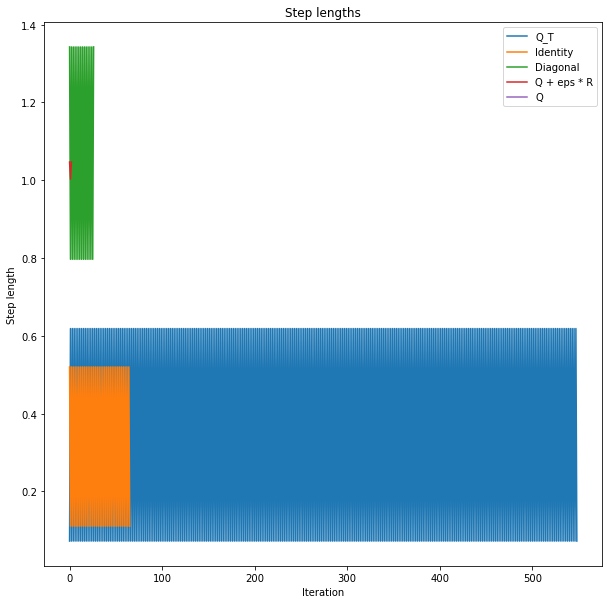

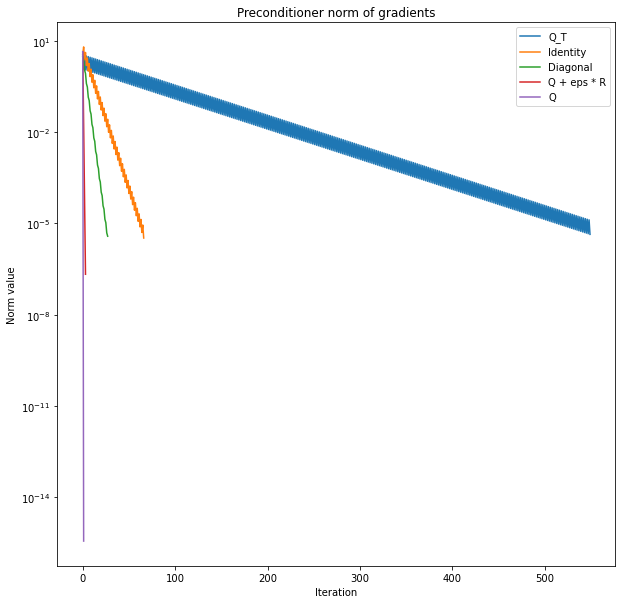

In [6]:
plot_step_sizes(list(out["history"] for out in outputs), labels)

plot_grad_norms(list(out["history"] for out in outputs), labels)

## Das Gradientenverfahren für nichtquadratische Funktionen

Quadratische Funktionen sind in der unbeschränkten Optimierung die einfachsten, sinnvoll zu untersuchenden Funktionen. 
Für Optimierungsaufgaben mit allgemeineren Funktionen ist das Verhalten des Gradientenverfahrens nicht mehr so leicht zu analysieren und vorherzusagen.
Außerdem ist die Wahl eines "nützlichen" Vorkonditionierers entsprechend schwieriger.
Wir werden jetzt das Verhalten des Gradientenverfahrens mit verschiedenen Vorkonditionierern und Armijo-Backtracking anhand der [Funktion von *Himmelblau*](https://en.wikipedia.org/wiki/Himmelblau%27s_function) - insbesondere hinsichtlich des Verhaltens bzgl. lokaler Minimierer untersuchen.


### Armijo Backtracking Strategie

Das Gradientenverfahren von oben können wir natürlich weiterverwenden.
Lediglich die Schrittweitensteuerung müssen wir austauschen, denn für allgemeine Funktionen finden wir keinen analytischen Ausdruck für eine exakte Schrittweite.
Wir werden stattdessen die im Skript beschriebene Backtracking Strategie mit der Armijo Regel implementieren.

**Aufgaben:** Vervollständigen Sie den Code zur Armijo Schrittweitensteuerung in der nächsten Zelle.

In [7]:
def armijo_backtracking(phi, reusables = {}, parameters = {}):
  """
  Compute a step length t via backtracking satisfying the Armijo condition 
  for the function phi, i.e.,

    phi(t) <= phi(0) + sigma * t * dphi(0) 

  where dphi(0) is the derivative of phi at t = 0.

  Accepts: 
           phi: evaluates the function the line search is performed on
     reusables: additional information that may be provided to the method (dictionary);
                the following key/value pairs are evaluated:
                   ["phi0"]: the value of phi at t = 0 (scalar)
                  ["dphi0"]: the value of the derivative of phi at t = 0 (scalar)

  Returns:
            t: the step length minimizing phi (provided it is quadratic)
     exitflag: flag encoding why the line search terminated
                 0: success
                 1: maximum number of iterations reached
                 2: trial step length became too small
  """

  def print_header():
    print('--------------------------------------------------------------------')
    print(' ARMIJO:     ITER          STEP      OBJCHNG           ')
    print('--------------------------------------------------------------------')
  
  # Get the line search parameters, using defaults if missing
  sigma = parameters.get("sigma", 0.01)
  beta = parameters.get("beta", 0.5)
  initial_t = parameters.get("initial_step_length", 1.0)
  verbosity = parameters.get("verbosity", "quiet")
  max_iterations = parameters.get("max_iterations", 1e4)
    
  # Extract or compute required data for checking armijo condition
  phi0 = reusables.get("phi0", phi(0, derivatives = [True, False, False])["function"]) or\
    phi(0, derivatives[True,False,False])["function"]
  dphi0 = reusables.get("dphi0", phi(0, derivatives = [False, True, False])["derivative"]) or\
    phi(0, derivatives[False,True,False])["derivative"]
  
  if dphi0 >= 0:
    raise(InputError('The function phi is expected to be decreasing at zero..'))
  
  # Initialize the step length and counter
  t = initial_t
  iter = 0
  exitflag = None
    
  # Perform the backtracking search until one of the termination criteria is met
  while exitflag is None:

    # Evaluate the value of phi at the current trial step length and the amount of descent
    phi_trial = phi(t, derivatives = [True, False, False])["function"]
    delta_phi = phi_trial - phi0
    
    # Dump some output
    if verbosity == 'verbose':
      if (iter%10 == 0): print_header()
      print('             %4d   %11.4e  %11.4e  \n' % (iter, t, delta_phi))
    
    # Verify the Armijo condition
    if delta_phi <= sigma * t * dphi0:
      exitflag = 0
      break
    # Stop when the maximum number of iterations has been reached
    elif iter >= max_iterations:
      exitflag = 1
      print('Warning: Armijo is stopping because the maximum number of iterations is reached.\n')
      break
    # Stop when the function appears locally constant and the initial step length has decreased significantly
    elif (delta_phi == 0) and (t / initial_t < 1e-12): 
      exitflag = 2                               
      if verbosity == 'verbose':
        print('Warning: Armijo is stopping because the function appears locally constant.\n')
      break
    
    # Reduce the trial step size and increase the counter
    t = beta * t
    iter = iter + 1
    
  # Check whether the step length is in fact positive
  if t < 0.0:
    raise ValueError('Armijio is returning a negative step length.')
  else:
    return t, exitflag

### Lokale Minimierer

Das Gradientenverfahren arbeitet mit lokalen Informationen.
Für nichtquadratische Funktionen, z.B. welche die mehrere stationäre Punkte haben, können wir nicht vorhersagen ob bzw. zu welchem Punkt das Verfahren konvergieren wird.
Im folgenden Skript soll das Gradientenverfahren für verschiedene Vorkonditionierer auf die Minimierung der Himmelblaufunktion angewendet und die Ergebnisse geplottet werden.

**Aufgabe:** Implementieren Sie zwei weitere Vorkonditionierer, nämlich:
1. Den Vorkonditionierer, der sich durch die Wahl der Hessematrix an der Startiterierten ergibt. (Der erste Schritt ist also ein Newton-Schritt)
1. Den Vorkonditionierer, der sich durch die Wahl der Hessematrix an einem Minimierer (3,2) ergibt.

--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
    0   2.8100e+03   1.7013e+03          nan         -inf
    1   3.8686e+02   3.6483e+02   1.3291e+01  -2.4231e+03
    2   1.7307e+02   2.2949e+01   5.7005e+00  -2.1379e+02
    3   7.9932e+00   3.4484e+01   2.8686e+00  -1.6508e+02
    4   1.7152e+00   1.7042e+01   5.3882e-01  -6.2780e+00
    5   8.1393e-01   1.1332e+01   2.6628e-01  -9.0125e-01
    6   2.8223e-01   6.9327e+00   1.7706e-01  -5.3171e-01
    7   1.1946e-01   4.5178e+00   1.0832e-01  -1.6276e-01
    8   4.4606e-02   2.8479e+00   7.0591e-02  -7.4856e-02
    9   1.8339e-02   1.8426e+00   4.4499e-02  -2.6266e-02
--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
   10 

No condition numbers plotable.


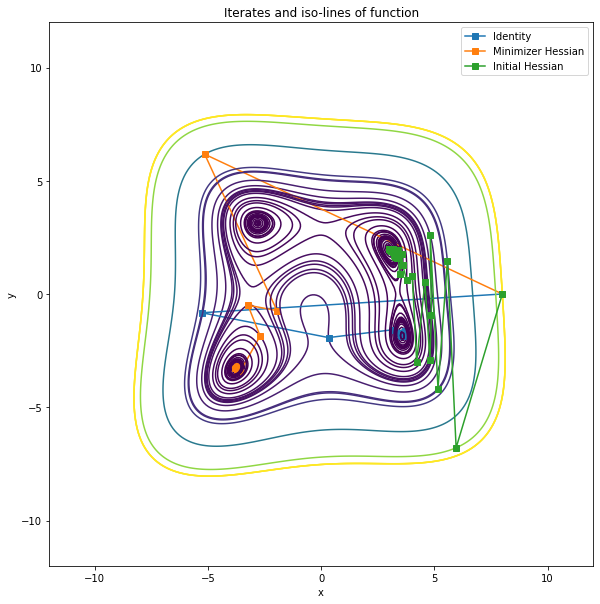

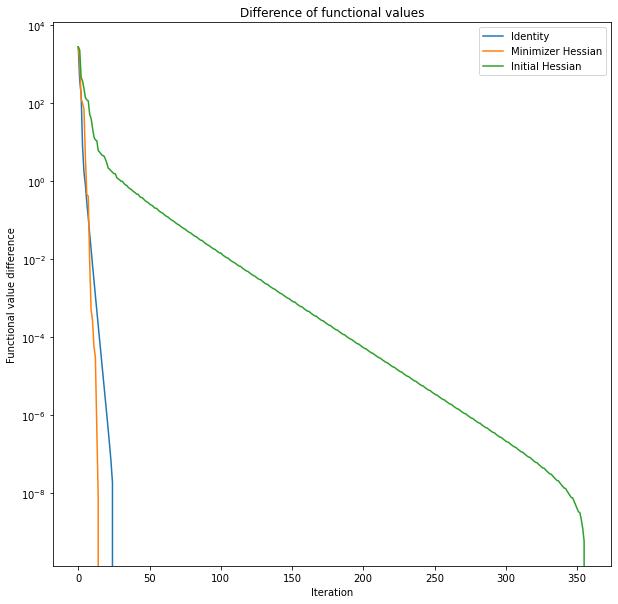

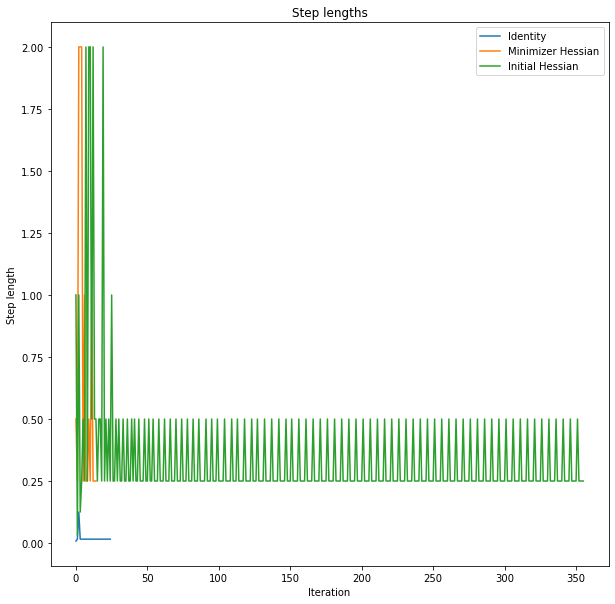

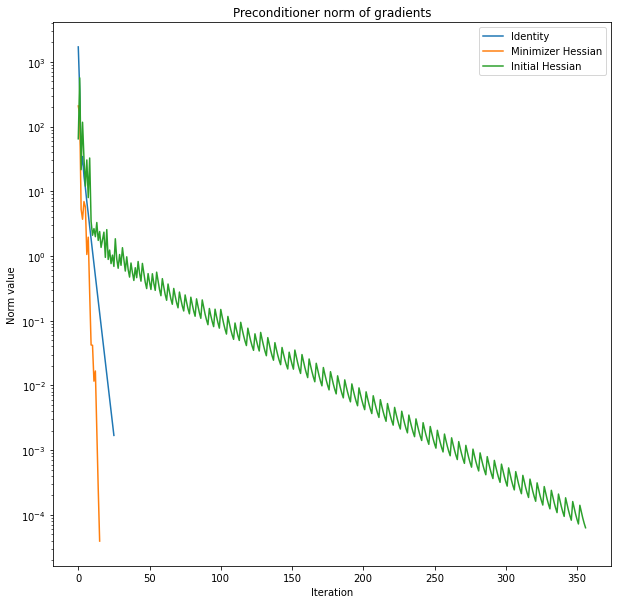

In [8]:
import sys
sys.path.append('src/')

import numpy as np

from objective_functions import *
from visualization_functions import *

# Create problem data
f = himmelblau
x0 = np.array([8.0, 0.0])

# Set parameters for armijo linesearch
armijo_parameters = {
"sigma" : 0.01,
"beta" : 0.5,
"initial_step_length" : 2,
#"verbosity" : "verbose"
}

# Construct step length rule
armijo_step_length_rule = lambda phi, reusables: armijo_backtracking(phi, reusables, armijo_parameters);

# Construct the preconditioners
preconditioners = [(np.identity(len(x0)), "Identity"), 
                  (f(np.array([3.0, 2.0]), derivatives = [False, False, True])['Hessian'], "Minimizer Hessian"),
                  (f(x0, derivatives = [False, False, True])['Hessian'], "Initial Hessian")]

# Set gradient scheme parameters
optimization_parameters = {
"atol_x" : 1e-7,
"rtol_x" : 1e-7,
"atol_f" : 1e-7,
"rtol_f" : 1e-14,
"max_iterations" : 1e4,
"c" : 10,
"verbosity" : "verbose",
"keep_history" : True
}

outputs = []
labels = []

# Solve problem for all preconditioners
for preconditioner, label in preconditioners:
  outputs.append(gradient_descent(f, x0, armijo_step_length_rule, preconditioner, optimization_parameters))
  labels.append(label)
    
# Plot history in iterate space
plot_2d_iterates_contours(f, list(out["history"] for out in outputs), labels)

# Plot functional value differences (approximation of error energy norm)
plot_f_val_diffs(list(out["history"] for out in outputs), 
                list(out["history"]["objective_values"][-1] for out in outputs),
                labels)

plot_step_sizes(list(out["history"] for out in outputs), labels)

plot_grad_norms(list(out["history"] for out in outputs), labels)

**Aufgabe:** Beschreiben Sie Ihre Beobachtungen zum Verhalten des obigen Beispiels. Variieren Sie auch den Startpunkt $x_0$ (Zeile 12) und erklären Sie, warum die Wahl der Hessematrix an der Startiterierten keine sonderlich gute Idee ist.

**TODO: Ihre Antwort hier.**

Wir beobachten unter anderem:
1. Jeder Durchlauf konvergiert zu einem anderen Minimierer der Funktion.
Die Wahl des Vorkonditionierers kann also dazu führen, dass das Resultat der Optimierung ein völlig anderes ist.
1. Die Wahl der Hessematrix der ersten Iterierten konvergiert hier am langsamsten, obwohl teilweise große Schrittweiten gewählt werden. (Plots 2 bis 4)
Informationen aus der Funktion helfen also nur bedingt.
1. Außerdem kann man bsplw. den Punkt $x_0 = (0,0)$ als Startpunkt wählen und kriegt eine Fehlermeldung zurück, denn die Funktion ist dort nicht lokal Konvex - die erste Hessematrix ist dort also nicht positiv definit.
Das ist genau ein Grund, warum man das Newton-Verfahren globalisiert.

## Das globalisierte Newton-Verfahren

Die Effekte, die sie in dem Beispiel der Himmelblaufunktion beobachtet haben zeigen, dass die unreflektierte Verwendung der Hessematrix als "adaptiver Vorkonditionierer" nicht funktionieren kann - daher verwendet man beim Newton-Verfahren die im Skript beschriebene globalisierte Variante.
Dass dieses Verfahren gegenüber dem Gradientenverfahren eine massive Verbesserung der Konvergenzgeschwindigkeit liefern kann, möchten wir anhand der [Rosenbrock Funktion](https://en.wikipedia.org/wiki/Rosenbrock_function) verifizieren.

### Implementierung des globalisierten Newton-Verfahrens
**Aufgabe:** Vervollständigen Sie den Code in der nächsten Zelle und führen Sie die Zelle aus.

In [9]:
import numpy as np

def globalized_newton(f, x0, step_length_rule, preconditioner, parameters = {}):
  """
  Solve an unconstrained minimization problem using the line search globalized newton method.
  
  Accepts:  
                   f: the objective function to be minimized
                  x0: the initial guess (list or numpy array with ndim == 1)
    step_length_rule: a step length computation function 
      preconditioner: a symmetric positive definite matrix (numpy array with ndim == 2)
          parameters: optional parameters (dictionary);
                      the following key/value pairs are evaluated:
                                    ["atol_x"]: absolute stopping tolerance for the norm of updates in x
                                    ["rtol_x"]: relative stopping tolerance for the norm of updates in x
                                    ["atol_f"]: absolute stopping tolerance for the progress in the values of f
                                    ["rtol_f"]: relative stopping tolerance for the progress in the values of f
                                ["atol_gradf"]: absolute stopping tolerance for the norm of the gradient of f
                                ["rtol_gradf"]: relative stopping tolerance for the norm of the gradient of f
                            ["max_iterations"]: maximum number of iterations
                                      ["rho1"]: globalization parameter
                                      ["rho2"]: globalization parameter
                                         ["p"]: globalization parameter
                                 ["verbosity"]: "verbose" or "quiet"
                              ["keep_history"]: whether or not to store the iteration history (True or False) 
                      Here 'norm' refers to the preconditioner-induced norm.
    
  Returns: 
              result: a dictionary containing 
                       solution: final iterate
                       function: the final iterate's objective value 
                       gradient: the final iterate's objective gradient value
                      norm_gradient: preconditioner-induced norm of final objective gradient 
                           iter: number of iterations performed
                       exitflag: flag encoding why the algorithm terminated
                                  0: stopping tolerance described by atol_x, rtol_x, atol_f, rtol_f reached
                                  1: stopping tolerance described by atol_gradf and rtol_gradf reached
                                  2: maximum number of iterations reached

                        history: a dictionary for the history of the run containing
                                              iterates: the iterates x
                                      objective_values: the values of the objective function
                                        gradient_norms: the norms of the objective function gradient 
                                         steps_lengths: the step lengths chosen by the step length rule
                                 used_newton_direction: the information whether or not the newton direction was used
  """
  # Define computation of the squared preconditioner norm
  def norm2(d): return d.dot(preconditioner.dot(d))
  
  # Define an output function that will be used to print information on the state of the iteration
  def print_header():
    print('--------------------------------------------------------------------')
    print(' ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           ')
    print('--------------------------------------------------------------------')
  
  # Define exitflags that will be printed when the algorithm terminates
  exitflag_messages = [
      'Relative and absolute tolerances on the norm of the update and the descent of the objective are satisfied.',
      'Relative and absolute tolerances on the norm of the gradient are satisfied.',
      'Maximum number of optimization steps is reached.',
      ]
  
  # Get the algorithmic parameters, using defaults if missing
  atol_x = parameters.get("atol_x", 1e-6)
  rtol_x = parameters.get("rtol_x", 1e-6)
  atol_f = parameters.get("atol_f", 1e-6)
  rtol_f = parameters.get("rtol_f", rtol_x**2)
  atol_gradf = parameters.get("atol_gradf", 1e-6)
  rtol_gradf = parameters.get("rtol_gradf", 1e-6)
  max_iterations = parameters.get("max_iterations", 1e3)
  rho1 = parameters.get("rho1", 1e-6)
  rho2 = parameters.get("rho2", 1e-6)
  p = parameters.get("p", 0.1)
  verbosity = parameters.get("verbosity", "quiet")
  keep_history = parameters.get("keep_history", False)

  # Initialize the iterates, counters etc.
  x = x0
  iter = 0
  exitflag = None
  used_newton_direction = None
  
  # Initialize dummy values pertaining to the previous iterate
  x_old = np.full(x0.shape, np.inf)
  function_value_old = np.inf

  # Prepare a dictionary to store the history
  if keep_history:
    history = {
      "iterates" : [],
      "objective_values" : [],
      "gradient_norms" : [],
      "step_lengths" : [],
      "used_newton_direction" : []
      }
  
  # Perform gradient descent steps until one of the termination criteria is met
  while exitflag is None:
    # Record the current iterate
    if keep_history: history["iterates"].append(x)
    
    # Dump some output
    if verbosity == 'verbose':
      if (iter%10 == 0): print_header()
      print(' %4d  ' % (iter), end = '')
            
    # Stop when the maximum number of iterations has been reached
    if iter >= max_iterations:
      exitflag = 2
      break
    
    # Compute the function value and derivative at current iterate
    values = f(x, derivatives = [True, True, True])
    function_value = values["function"]
    derivative = values["derivative"]
    hessian = values["Hessian"]
    
    # Record the current value of the objective
    if keep_history: history["objective_values"].append(function_value)
        
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  ' % (function_value), end = '')
    
    # Compute the preconditioned gradient and the square of its (preconditioner-induced) norm
    gradient = np.linalg.solve(preconditioner, derivative)
    norm2_gradient = derivative.dot(gradient)
    
    # Check the computed norm square for positivity
    if norm2_gradient < 0:
      raise ValueError('Your preconditioner appears not to be positive definite.')
    else:
      norm_gradient = np.sqrt(norm2_gradient)
    
    # Record the current norm of the gradient
    if keep_history: history["gradient_norms"].append(norm_gradient)

    # Remember the norm of the initial gradient
    if (iter == 0): initial_norm_gradient = norm_gradient
        
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  ' % (norm_gradient), end = '')
    
    # Stop when the stopping tolerance on the norm of the gradient has been reached
    if norm_gradient <= atol_gradf + rtol_gradf * initial_norm_gradient:
      exitflag = 1
      break
    
    # Evaluate the norm of the update step
    norm_delta_x = np.sqrt(norm2(x - x_old))
    
    # Evaluate the change in the objective function values
    delta_f = function_value_old - function_value
    
    # Evaluate the reference values for relative tolerances
    abs_function_value_old = np.abs(function_value_old)
    norm_x_old = np.sqrt(norm2(x_old))
    
    # Dump some output
    if verbosity == 'verbose': print('%11.4e  %11.4e' % (norm_delta_x, -delta_f))
    
    # Stop when the stopping tolerance on the change in the objective and the
    # norm of the update step have been reached
    if (delta_f < atol_f + rtol_f * abs_function_value_old) and\
      (norm_delta_x < atol_x + rtol_x * norm_x_old):
      exitflag = 0
      break
    
    # Set the update direction
    try:
      # Compute Newton direction and its (preconditioner induced) norm
      d = np.linalg.solve(hessian, -derivative)
      norm2_d = norm2(d)
      
      # Check Newton direction for quality
      if -derivative.dot(d) <= min(rho1, rho2 * norm2_d ** (p/2)) * norm2_d:
        raise ValueError("Newton direction is of poor quality")
      used_newton_direction = True
    except:
      # Fall back to gradient direction if Newton direction could not be computed or is of poor quality
      used_newton_direction = False
      d = -gradient
    
    # Prepare the line search function, using the function values of the
    # objective and its derivatives and the chain rule
    def phi(t, derivatives):
      values = f(x + t * d, derivatives)
      if derivatives[1]:
        values["derivative"] = values["derivative"].dot(d)
      if derivatives[2]:
        values["Hessian"] = d.dot(values["Hessian"].dot(d))
      return values
    
    # Prepare some data to pass down to the step length computation rule
    reusables = {
      "phi0" : function_value,
      }
    if not used_newton_direction: reusables["dphi0"] = -norm2_gradient
    
    # Evaluate the step length t using the step length rule
    t, t_exitflag = step_length_rule(phi, reusables)
    
    # Check whether of not the step length was computed succesfully
    if t_exitflag: raise AssertionError('Step length was not computed succesfully.')
    
    # Record the chosen step length 
    if keep_history: history["step_lengths"].append(t)
    
    # Save the current iterate and associated function value for the next iteration
    x_old = x
    function_value_old = function_value
    
    # Update the iterate and increase the counter
    x = x + t * d
    iter = iter + 1

    # Remember whether or not the newton direction was used as update direction
    if keep_history: history["used_newton_direction"].append(used_newton_direction)

  # Dump some output
  if verbosity == 'verbose':
    print('\n\nThe globalized newton is exiting with flag %d.\n' %(exitflag) + str(exitflag_messages[exitflag])+'\n' )
  
  # Create and populate the result to be returned
  result = {
    "solution" : x,
    "function" : function_value,
    "gradient" : gradient,
    "norm_gradient" : norm_gradient,
    "iter" : iter,
    "exitflag" : exitflag
    }

  # Assign the history to the result if required
  if keep_history:
    result["history"] = history
      
  return result

Im folgenden Skript wird das globalisierte Newton-Verfahren im Vergleich zum euklidisch vorkonditionierten Gradientenverfahren für die Minimierung der Rosenbrock Funktion verwendet.

**Aufgabe:** Vervollständigen Sie das Skript und führen Sie es aus. Beachten Sie die Bedingungen, die im Skript an die Parameter gestellt werden.

--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
    0   3.1977e+01   1.1905e+02          nan         -inf
    1   8.9584e+00   7.0904e+01   3.7203e+00  -2.3018e+01
    2   8.5025e+00   5.0675e+01   5.5394e-01  -4.5589e-01
    3   1.5113e+00   2.4015e+01   3.9590e-01  -6.9912e+00
    4   1.1276e+00   1.7799e+01   1.8762e-01  -3.8373e-01
    5   6.3737e-01   1.1904e+01   1.3905e-01  -4.9022e-01
    6   5.1138e-01   8.6934e+00   9.2999e-02  -1.2599e-01
    7   4.1049e-01   6.0252e+00   6.7917e-02  -1.0089e-01
    8   3.7307e-01   4.3437e+00   4.7072e-02  -3.7419e-02
    9   3.4898e-01   3.0487e+00   3.3935e-02  -2.4096e-02
--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
   10 

  999   3.0707e-07   1.2156e-03   2.2191e-05  -2.7230e-09
--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
--------------------------------------------------------------------
 1000   2.9940e-07   8.1503e-04   1.8993e-05  -7.6726e-09
 1001   2.9437e-07   6.1667e-04   1.2735e-05  -5.0252e-09
 1002   2.8995e-07   9.6614e-04   1.9271e-05  -4.4270e-09
 1003   2.8416e-07   6.8423e-04   1.5096e-05  -5.7845e-09
 1004   2.8177e-07   1.1755e-03   2.1382e-05  -2.3943e-09
 1005   2.7464e-07   7.8638e-04   1.8367e-05  -7.1235e-09
 1006   2.7001e-07   5.9325e-04   1.2287e-05  -4.6385e-09
 1007   2.6600e-07   9.3326e-04   1.8539e-05  -4.0029e-09
 1008   2.6065e-07   6.5918e-04   1.4582e-05  -5.3534e-09
 1009   2.5855e-07   1.1365e-03   2.0599e-05  -2.1023e-09
--------------------------------------------------------------------
 ITER          OBJ    NORM_GRAD    NORM_CORR     OBJ_CHNG           
-----------------

No condition numbers plotable.


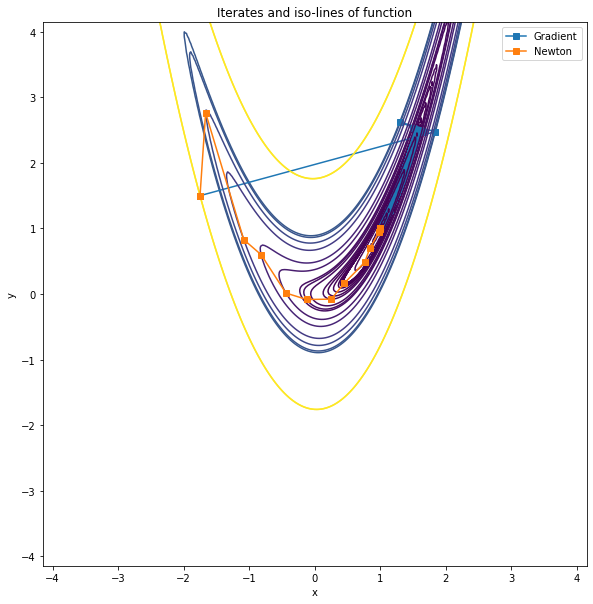

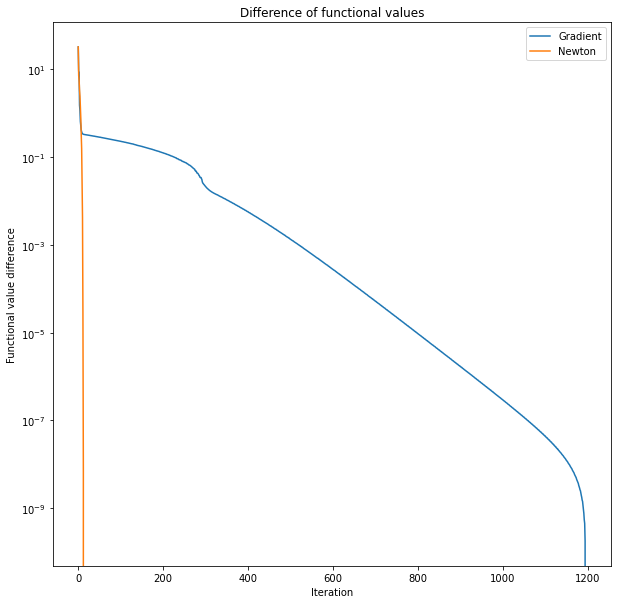

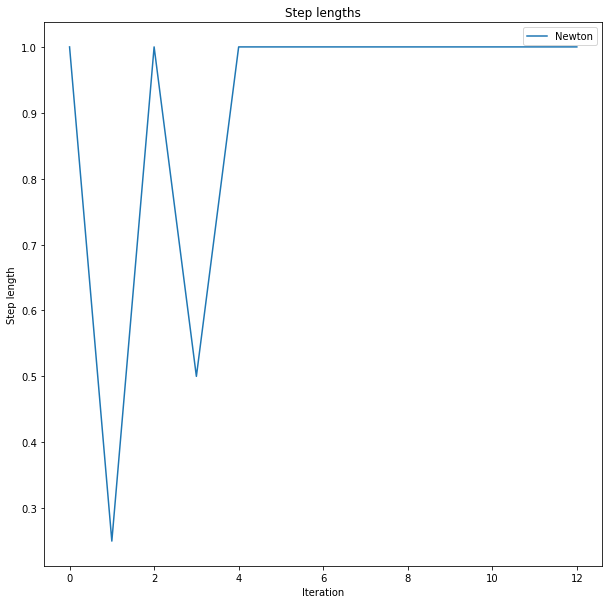

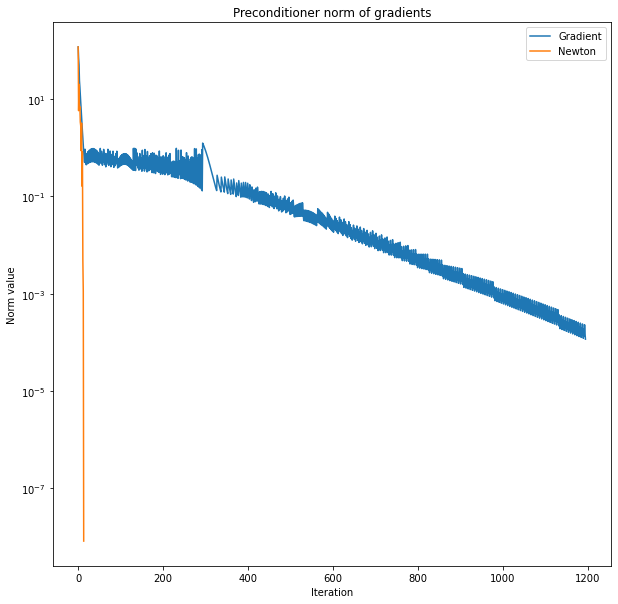

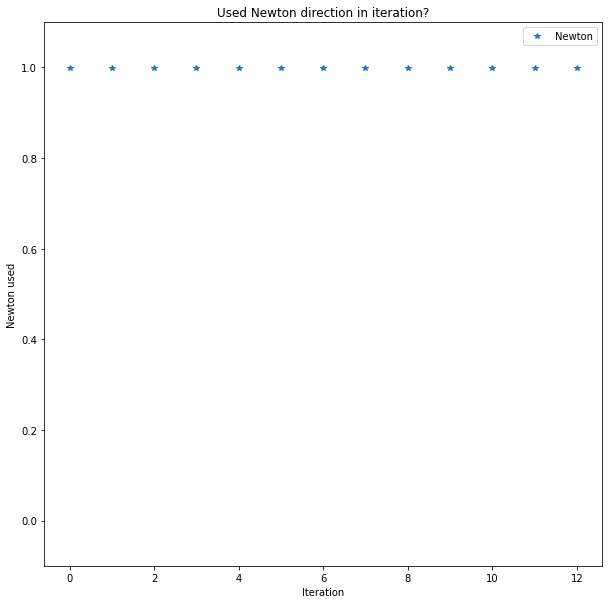

In [10]:
import sys
sys.path.append('src/')

import numpy as np

from objective_functions import *
from visualization_functions import *

# Create problem data
rosenbrock_parameters = {
    "a" : 1,
    "b" : 10,
  }
f = lambda x, derivatives: rosenbrock(x, derivatives, rosenbrock_parameters)
x0 = np.array([-1.75, 1.5])

# Set parameters for armijo linesearch
armijo_parameters = {
"sigma" : 0.01,
"beta" : 0.5,
"initial_step_length" : 1,
#"verbosity" : "verbose"
}

if not armijo_parameters["sigma"] < 0.5:
  raise ValueError('Chosen armijo sigma is not smaller than 0.5')
if not armijo_parameters["initial_step_length"] == 1:
  raise ValueError('Initial step length is not 1.')

# Construct step length rule
armijo_step_length_rule = lambda phi, reusables: armijo_backtracking(phi, reusables, armijo_parameters);

# Set optimization parameters
optimization_parameters = {
"atol_x" : 1e-7,
"rtol_x" : 1e-7,
"atol_f" : 1e-7,
"rtol_f" : 1e-14,
"max_iterations" : 1e10,
"c" : 10,
"verbosity" : "verbose",
"keep_history" : True
}

# Solve problem using preconditioned gradient scheme
gradient_output = gradient_descent(f, x0, armijo_step_length_rule, preconditioner = np.identity(len(x0)), parameters = optimization_parameters)
gradient_label = "Gradient"
  
# Solve problem using globalized Newton scheme
newton_output = globalized_newton(f, x0, armijo_step_length_rule, preconditioner = np.identity(len(x0)), parameters = optimization_parameters)
newton_label = "Newton"

# Prepare data for plotting
histories = [gradient_output["history"], newton_output["history"]]
labels = [gradient_label, newton_label]

# Plot history in iterate space
plot_2d_iterates_contours(f, histories, labels)

# Plot functional value differences (approximation of error energy norm)
plot_f_val_diffs(histories, 
                list(hist["objective_values"][-1] for hist in histories),
                labels)

plot_step_sizes([newton_output["history"]], [newton_label])

plot_grad_norms(histories, labels)

plot_used_newton_direction([newton_output["history"]], [newton_label])


**Aufgabe:** Beschreiben Sie ihre Beobachtungen zum Konvergenzverhalten der beiden Verfahren.
Warum eignet sich die Rosenbrock Funktion gut für diesen Vergleich? Bringt dem Gradientenverfahren die Wahl anderer Vorkonditionerer einen Vorteil?

**TODO: Ihre Antwort hier**

Wir beobachten: 
Beide Verfahren liefern zügig Iterierte, die in dem gekrümmten Tal liegen.
Das Gradientenverfahren beginnt nun sehr langsam und im Zick-Zack das gekrümmte Tal entlang zu laufen.
Die Schrittweiten sind verhältnismäßig klein.
Das Newton-Verfahren hingegen nutzt die Newton Richtung tatsächlich auch in jedem Schritt und kann gegen Ende immer die volle Schrittweite gehen (hier wird also die lokal quadratische Konvergenz erreicht).
Da das Tal seine Richtung ändert sind auch fest gewählte Vorkonditionierer dem Gradientenverfahren nur eine kleine Hilfe.
Das Newton-Verfahren profitiert hier von seinen aufdatierten Informationen zur Krümmung.

# Bonus

Wenn sie alle Funktionalitäten bis hier entwickeln konnten steht es Ihnen natürlich frei, ihre Lösung zu kopieren und in der Kopie beliebige Änderungen an den Parametern vorzunehmen. 
Eine genauerer Vergleich des Einflusses der Schrittweitenbestimmungen auf das Gradientenverfahren ist bspl. eine weitere interessante Untersuchung, die dem Verständnis der Parameter im Armijo hilfreich ist.